# Audio Classification  

## Spectrogram classification 모델 구현  
- 2차원 Spectrogram 데이터를 입력받아 위 모델과 동일한 역할을 수행하는 모델
- 기본 버전과 Skip-connection 버전으로 나누어 각각 진행

## 데이터 처리와 분류

In [1]:
import numpy as np
import os

#데이터 저장 및 불러오기
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)
print("✅")

✅


In [2]:
# npz파일로 이뤄진 데이터 저장 확인
print("Wave data shape : ", speech_data["wav_vals"].shape) 
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


데이터셋 1초길이 오디오 음성데이터 50620개  
데이터의 Sample rate는 16000개 이지만, 8000으로 re-sampling  
모두 1초의 길이를 가지는 오디오 음성데이터 - 각각 8000개의 sample data 있다

In [3]:
#데이터 확인
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  16458
Wave data shape :  (8000,)
label :  ['stop']


### Train/Test 데이터셋 구성

#### Spectrogram ?  
- 일정 시간동안 wav 데이터 안의 다양한 주파수들이 얼마나 포함되어 있는지 보여준다.  
#### 2차원 Spectrogram 으로 변환

In [4]:
# Spectrogram 데이터 생성
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")


✅


In [6]:
spec_data=[] #빈깡통을 만들어준다.

for wav in speech_data["wav_vals"][:15000]: #1차원 wav 하나씩 가져온다. 커널이 자꾸 끊어져 데이터양 축소
    spec = wav2spec(wav)
    spec_data.append(spec)
    
spec_data = np.array(spec_data)
spec_data.shape

(15000, 130, 126)

In [9]:
# Label data 처리 : Text -> index 형태로 바꾸기
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [10]:
# int index로 변환
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

In [11]:
# 정답 데이터도 데이터양 축소 / 2차원 변환
label_data=label_data[:15000]
label_data.shape

(15000,)

### 학습을 위한 데이터 분리
- sklearn의 train_test_split 함수를 이용해 train data와 test data를 분리

In [13]:
from sklearn.model_selection import train_test_split


train_spec, test_spec, train_label, test_label = train_test_split(spec_data, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
train_spec = train_spec.reshape([-1, 130,126, 1]) # add channel for CNN
test_spec = test_spec.reshape([-1, 130,126, 1])
print("✅")

✅


In [16]:
# 나눠진 데이터셋 확인
print("train data : ", train_spec.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_spec.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (13500, 130, 126, 1)
train labels :  (13500,)
test data :  (1500, 130, 126, 1)
test labels :  (1500,)
✅


## 학습을 위한 하이퍼파라미터 설정

In [17]:
# 모델 체크포인트 Callback 함수를 설정 / 모델 불러올 때 사용
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel/aiffel/speech_recognition/models/wav'

## 데이터셋 구성

In [18]:
# map함수에 넘겨줄 데이터 전처리 함수
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [20]:
# tf.data.Dataset함수 구성 - 데이터셋 전처리, 배치처리 쉽게 해준다.

import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
                # return 받길 원하는 데이터를 튜플(data,label) 형태로 넣어서 사용
train_dataset = train_dataset.map(one_hot_label)
                # dataset이 데이터를 불러올때마다 동작시킬 데이터 전처리 함수 매핑해주는 역할
train_dataset = train_dataset.repeat().batch(batch_size=batch_size) 
                #batch는 dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


In [25]:
#데이터 비워주기
# 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.

#tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.

#del speech_data
#del spec_data


## 2차원 Spectrogram 데이터 처리 모델 구성

In [22]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130,126,1))   #(130,126)은 spec_shape

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model( input_tensor, output_tensor,name='basic_model')

model_spec.summary()

Model: "basic_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        

In [23]:
# 12개 단어 class 구분하는 Loss/Adam optimizer 사용
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [24]:
# 모델 가중치 저장하는 checkpoint callback 함수 추가
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
    #모델 학습을 진행하며 fit함수 내 다양한 인자를 지정해 모니터하며 동작하게 설정
print("✅")

✅


In [25]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
421/421 [==============================] - ETA: 0s - loss: 0.8509 - accuracy: 0.7082
Epoch 00001: val_loss improved from inf to 0.39297, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
421/421 [==============================] - 62s 147ms/step - loss: 0.8509 - accuracy: 0.7082 - val_loss: 0.3930 - val_accuracy: 0.8832
Epoch 2/10
421/421 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.9161
Epoch 00002: val_loss improved from 0.39297 to 0.16581, saving model to /home/aiffel/aiffel/speech_recognition/models/wav
421/421 [==============================] - 61s 146ms/step - loss: 0.2618 - accuracy: 0.9161 - val_loss: 0.1658 - val_accuracy: 0.9477
Epoch 3/10
421/421 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.9414
Epoch 00003: val_loss did not improve from 0.16581
421/421 [==============================] - 63s 149ms/step - loss: 0.1813 - accuracy: 0.9414 - val_loss: 0.2076 - val_accuracy: 0.9300
Epoch 4/10
421/421 

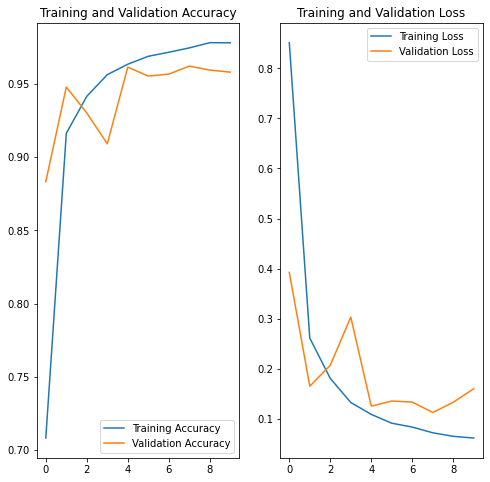

✅


In [27]:
# 학습이 어떻게 진행 됐는지 loss, accuracy 그래프로 표현
import matplotlib.pyplot as plt

acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

## Test dataset을 이용해서 모델의 성능을 평가

In [29]:
#checkpoint callback 함수가 저장한 weight를 다시 불러와서 테스트 준비
model_spec.load_weights(checkpoint_dir)  

# test data를 이용하여 모델의 예측값과 실제값이 얼마나 일치하는지 확인 
results = model_spec.evaluate(test_dataset)

47/47 [==============================] - 11s 239ms/step - loss: 0.1115 - accuracy: 0.9627


In [30]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 0.111
accuracy value: 96.2667%
✅


### Model Test
- Test data set 골라 모델 예측 확인

In [47]:
#Test data set을 골라 직접 들어보고 모델의 예측이 맞는지 확인
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spec(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

#ipd.Audio(batch_xs.reshape(16380,), rate=8000)

label :  on


In [48]:
# 테스트셋 라벨과 우리 모델의 실제 prediction 결과 비교 
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: on(Correct!)
✅


# Skip-Connection model 구현  
### 2차원 모델 구성

In [51]:
input_tensor = layers.Input(shape=(130,126 ,1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 130, 126, 32) 2624        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 130, 126, 32) 82976       conv2d_14[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 65, 63, 32)   0           conv2d_15[0][0]                  
______________________________________________________________________________________________

In [52]:
# 12개 단어 class 구분하는 Loss/Adam optimizer 사용
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [53]:
# the save point
# 모델 가중치 저장하는 checkpoint callback 함수 추가
import os
import tensorflow as tf
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [55]:
#30분 내외 소요

history_spec_skip = model_spec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

print("✅")

Epoch 1/10
421/421 [==============================] - ETA: 0s - loss: 0.9360 - accuracy: 0.6876
Epoch 00001: val_loss improved from inf to 0.53444, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
421/421 [==============================] - 66s 158ms/step - loss: 0.9360 - accuracy: 0.6876 - val_loss: 0.5344 - val_accuracy: 0.8200
Epoch 2/10
421/421 [==============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.9234
Epoch 00002: val_loss improved from 0.53444 to 0.22263, saving model to /home/aiffel/aiffel/speech_recognition/models/wav_skip
421/421 [==============================] - 67s 159ms/step - loss: 0.2419 - accuracy: 0.9234 - val_loss: 0.2226 - val_accuracy: 0.9246
Epoch 3/10
421/421 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.9532
Epoch 00003: val_loss did not improve from 0.22263
421/421 [==============================] - 67s 160ms/step - loss: 0.1510 - accuracy: 0.9532 - val_loss: 0.2324 - val_accuracy: 0.9287
Epoch 4/1

### 학습이 어떻게 진행 됐는지 loss, accuracy 그래프로 표현

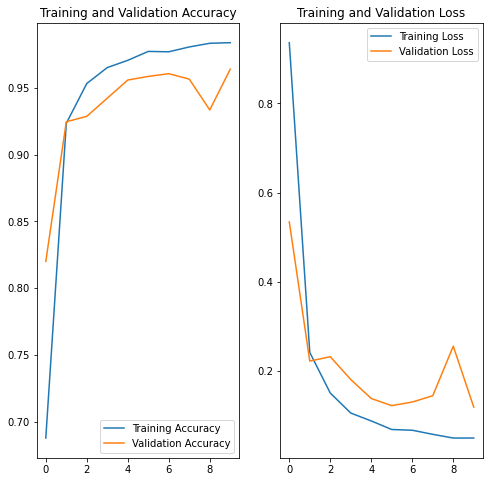

✅


In [56]:
import matplotlib.pyplot as plt

acc = history_spec_skip.history['accuracy']
val_acc = history_spec_skip.history['val_accuracy']

loss=history_spec_skip.history['loss']
val_loss=history_spec_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

 ### Test dataset을 이용해서 모델의 성능을 평가

In [57]:
# Evaluation 

model_spec_skip.load_weights(checkpoint_dir)
results = model_spec_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

47/47 [==============================] - 5s 99ms/step - loss: 0.1180 - accuracy: 0.9640
loss value: 0.118
accuracy value: 96.4000%
✅


In [59]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spec_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

#ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  go


In [60]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: go(Correct!)
✅


---
## 루브릭 평가 요구사항  
  
### 1) 음성데이터를 2차원 Spectrogram 으로 변환하여 스펙트로그램 시각화 및 train/test 데이터셋을 구성하였다.
- wav2spec 함수를 이용하여 1차원 Waveform 데이터를 2차원 Spectrogram 데이터로 변환하였으며, shape도 변화시켜 주었다.  

### 2)  스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계가 정상 작동한다.
-  스펙트로그램 모델 학습 후 loss와 accuracy 그래프를 보고 train과 validation의 차이가 크지 않고, accuracy도 96% 이상으로 나타났다.

### 3) 테스트셋 수행결과 음성인식 모델의 Accuracy가 75% 이상의 정확도를 달성하였다.
- 테스트셋 수행 결과 음성인식 모델의 accuracy가 두가지 모델 모두 96%이상 나타났다.

---
# 회고  

가장 먼저 프로젝트를 진행하며 음성데이터 train을 하는데에 있어 시간이 너무 오래 걸린다는 것이 단점이였다. 한번 오류가 나면 다시 오래걸리는 train을 진행해야하니 많이 지치기도 하였다. spec_data를 append하는 과정에서 커널이 계속 끊겨 입력 데이터셋을 15000까지 줄이게 되었다. 데이터양을 줄이니 확실히 training 시간도 줄긴 했지만, 올바른 모델로 평가할 수 있을지는 의문이였다. 최종적으로 두가지 모델 모두 96%이상 정확도가 나타나긴 했지만, 궁금증이 투성이였던 프로젝트라 이후 코드에 대하여 더 자세히 공부해보아야겠다.

---